In [2]:
"""
Optimized for Apple M2 Pro
"""
import os
import time
import pickle

import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from functools import partial
import math
from scipy.spatial.transform import Rotation
import itertools

# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from spectra import sum_of_diracs, bispectrum

#------------------------------------------------------------------------------
# JAX & Hardware Configuration
#------------------------------------------------------------------------------

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_default_matmul_precision', 'high')

#------------------------------------------------------------------------------
# Constants
#------------------------------------------------------------------------------

LMAX = 5
NUM_INITS = 20

#------------------------------------------------------------------------------
# Helpers
#------------------------------------------------------------------------------

def determine_optimal_batch_size() -> int:
    """Pick a default batch size: 8 on M1/M2 silicon, else 5."""
    try:
        import platform
        return 8 if platform.processor() == 'arm' else 5
    except:
        return 5

@jax.jit
def compute_bispectrum_for(env):
    """Compute bispectrum for an (M×3) array, zeros allowed."""
    return bispectrum(sum_of_diracs(env, LMAX))

@partial(jax.jit, static_argnums=(2,))
def invert_with_adam(true_bs, init_pts, num_iters=10000):
    """Adam-based inversion."""
    lr = 1e-2
    opt = optax.adam(lr)
    state = opt.init(init_pts)
    def loss_fn(x):
        pred_bs = bispectrum(sum_of_diracs(x, LMAX))
        return jnp.mean(jnp.abs(true_bs - pred_bs))
    def step(carry, _):
        pts, st = carry
        g = jax.grad(loss_fn)(pts)
        updates, st = opt.update(g, st, pts)
        return (optax.apply_updates(pts, updates), st), None
    (final_pts, _), _ = jax.lax.scan(step, (init_pts, state), None, length=num_iters)
    return final_pts

def stack_points(points: np.ndarray) -> jnp.ndarray:
    """
    Cluster points by alignment (cosine > 0.866), sum and threshold
    with half the max norm. Returns (K×3) JAX array or empty.
    """
    norms = np.linalg.norm(points, axis=1, keepdims=True)
    valid = norms[:,0] > 0
    pts = points.copy()
    pts[valid] /= norms[valid]
    D = pts @ pts.T
    used = np.ones(len(points),bool)
    clusters = []
    while used.any():
        i = np.argmax(used)
        aligned = (D[i] > 0.866) & used
        if not aligned.any(): break
        clusters.append(points[aligned].sum(0))
        used[aligned] = False
    if not clusters:
        return jnp.zeros((0,3), jnp.float64)
    C = np.stack(clusters)
    norms = np.linalg.norm(C, axis=1)
    thresh = 0.5 * norms.max()
    C = C[norms >= thresh]
    return jnp.array(C, jnp.float64)



def align_predicted_geometry(true_geometry: np.ndarray,
                             predicted_geometry: np.ndarray
                            ) -> tuple[np.ndarray, float]:
    """
    Aligns `predicted_geometry` onto `true_geometry` using only a rigid-body rotation.
    Points are first sorted by distance from the origin, normalized to unit radius,
    then each pair of corresponding direction‐vectors is scaled by a different
    random weight (to break any geometric symmetry) before computing the optimal
    rotation. Assumes both inputs are centered at the origin.

    Parameters
    ----------
    true_geometry : (N, 3) array_like
        Reference point cloud, centered at the origin.
    predicted_geometry : (N, 3) array_like
        Point cloud to align, also centered.

    Returns
    -------
    aligned_predicted : (N, 3) ndarray
        The `predicted_geometry` rotated to best match `true_geometry`.
    rmsd : float
        The RMSD between the (weighted) direction‐vectors after optimal alignment.
    """
    # Convert inputs
    true_pts = np.asarray(true_geometry, dtype=float)
    pred_pts = np.asarray(predicted_geometry, dtype=float)
    if true_pts.shape != pred_pts.shape or true_pts.shape[1] != 3:
        raise ValueError("Both inputs must have shape (N, 3)")

    # Compute norms (radii) without sorting
    true_radii = np.linalg.norm(true_pts, axis=1)
    pred_radii = np.linalg.norm(pred_pts, axis=1)
    
    # Normalize to unit vectors directly without reordering
    true_dirs = true_pts / true_radii[:, None]
    pred_dirs = pred_pts / pred_radii[:, None]    

    # Generate a different random weight for each point to break symmetry
    # (e.g. uniform on [0,1) or any other distribution)
    weights = np.random.rand(true_dirs.shape[0], 1)

    # Scale both sets by the same per-point weights
    true_weighted = true_dirs * weights
    pred_weighted = pred_dirs * weights

    # Compute optimal rotation on weighted directions
    rot, rmsd = Rotation.align_vectors(true_weighted, pred_weighted)

    # Apply rotation back to the original predicted points
    pred_rotated = rot.apply(pred_pts)

    return pred_rotated, rmsd


def alignment_mae(true_geometry, predicted_geometry):

    true_geometry = np.array(true_geometry)
    predicted_geometry = np.array(predicted_geometry)

    if true_geometry.shape != predicted_geometry.shape:
        return float('inf')

    # Try all permutations of the predicted geometry and select the one with lowest RMSD
    best_error = float('inf')
    best_aligned = None
    
    # Get all permutations of indices
    n_points = predicted_geometry.shape[0]
    for perm in itertools.permutations(range(n_points)):
        perm_predicted = predicted_geometry[list(perm)]
        aligned, _ = align_predicted_geometry(true_geometry, perm_predicted)
        error = jnp.mean(jnp.linalg.norm(aligned - true_geometry, axis=1))
        # error = np.mean(np.abs(aligned - true_geometry), axis=1)
        if error < best_error:
            best_error = error
            best_aligned = aligned

    return best_error, best_aligned

In [3]:
with open('../data/qm9_local_envs.pkl', 'rb') as f:
    local_envs = pickle.load(f)

local_envs = local_envs[:100000]

local_envs = [jnp.array(local_env) for local_env in local_envs]
train_geometries = local_envs[:99900]
test_geometries = local_envs[99900:]

print(f"Number of local environments: {len(local_envs)}")

bispectra = [compute_bispectrum_for(local_env) for local_env in local_envs]

train_bispectra = jnp.array(bispectra[:99900])
test_bispectra = jnp.array(bispectra[99900:])

Number of local environments: 100000


In [4]:
# with open('../data/qm9_local_envs_10000.pkl', 'rb') as f:
#     local_envs = pickle.load(f)

# local_envs = [jnp.array(local_env) for local_env in local_envs]
# train_geometries = local_envs[:9900]
# test_geometries = local_envs[9900:]

# print(f"Number of local environments: {len(local_envs)}")

# bispectra = [compute_bispectrum_for(local_env) for local_env in local_envs]

# train_bispectra = jnp.array(bispectra[:9900])
# test_bispectra = jnp.array(bispectra[9900:])

In [34]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit
import flax.linen as nn
import optax
from flax.training import train_state
import numpy as np
from typing import Any, Dict
from functools import partial

# Set random seed for reproducibility
key = random.PRNGKey(42)

# Hyperparameters
input_dim = 22       # Length of bispectrum vectors
latent_dim = 2       # Dimension of the latent space
hidden_dim = 128     # Hidden layer dimension
batch_size = 256
learning_rate = 1e-3
num_epochs = 1000
kl_weight = 0      # Weight for KL regularization term

# Modified Autoencoder Model with separate encoder and decoder methods
class Autoencoder(nn.Module):
    hidden_dim: int
    latent_dim: int
    
    def setup(self):
        # Encoder layers
        self.encoder_layer1 = nn.Dense(self.hidden_dim)
        self.encoder_layer2 = nn.Dense(self.hidden_dim)
        self.encoder_output = nn.Dense(self.latent_dim)
        
        # Decoder layers
        self.decoder_layer1 = nn.Dense(self.hidden_dim)
        self.decoder_layer2 = nn.Dense(self.hidden_dim)
        self.decoder_output = nn.Dense(input_dim)
    
    def encode(self, x):
        x = self.encoder_layer1(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = self.encoder_layer2(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        return self.encoder_output(x)
    
    def decode(self, z):
        x = self.decoder_layer1(z)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = self.decoder_layer2(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        return self.decoder_output(x)
    
    def __call__(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed, latent

# Loss function with KL regularization (not JIT-compiled directly)
def loss_fn(params, batch, model):
    reconstructed, latent = model.apply({'params': params}, batch)
    
    # Reconstruction loss (MSE)
    recon_loss = jnp.mean(jnp.sum((reconstructed - batch) ** 2, axis=1))
    
    # KL divergence regularization
    kl_loss = 0.5 * jnp.mean(jnp.sum(latent ** 2 - jnp.log(latent ** 2 + 1e-8) - 1, axis=1))
    
    # Total loss
    total_loss = recon_loss + kl_weight * kl_loss
    
    return total_loss, (recon_loss, kl_loss)

# Create a non-JIT train step that we'll later partially apply with the model
def train_step_fn(model, state, batch):
    def loss_step(params):
        loss, (recon_loss, kl_loss) = loss_fn(params, batch, model)
        return loss, (recon_loss, kl_loss)
    
    grad_fn = jax.value_and_grad(loss_step, has_aux=True)
    (loss, (recon_loss, kl_loss)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    return state, loss, recon_loss, kl_loss


# Prepare batches of data
def get_batches(data, batch_size, shuffle=True):
    num_samples = data.shape[0]
    indices = jnp.arange(num_samples)
    
    if shuffle:
        # Shuffle indices
        key = random.PRNGKey(0)
        indices = random.permutation(key, indices)
    
    # Create batches
    num_batches = num_samples // batch_size
    batches = []
    for i in range(num_batches):
        batch_indices = indices[i * batch_size:(i + 1) * batch_size]
        batches.append(data[batch_indices])
    
    return batches

# Main training function
def train_autoencoder(model, data, num_epochs, batch_size, learning_rate):
    # Initialize model parameters
    key = random.PRNGKey(0)
    dummy_input = jnp.ones((1, input_dim))
    params = model.init(key, dummy_input)['params']  # Extract only 'params'
    
    # Create optimizer
    tx = optax.adam(learning_rate)
    
    # Create training state (standard Flax training state without model)
    state = train_state.TrainState.create(
        apply_fn=None,  # Not needed since we use model.apply directly
        params=params,
        tx=tx
    )
    
    # Create a JIT-compiled step function by partially applying the model
    # This way the model is captured in the closure and isn't passed as a dynamic argument
    jitted_train_step = jit(partial(train_step_fn, model))
    
    # Prepare batches
    batches = get_batches(data, batch_size)
    
    # Training loop
    loss_history = {'total': [], 'recon': [], 'kl': []}
    
    for epoch in range(num_epochs):
        epoch_loss, epoch_recon_loss, epoch_kl_loss = 0.0, 0.0, 0.0
        
        for batch in batches:
            # Use the JIT-compiled function with the model already applied
            state, loss, recon_loss, kl_loss = jitted_train_step(state, batch)
            epoch_loss += loss
            epoch_recon_loss += recon_loss
            epoch_kl_loss += kl_loss
        
        # Average losses
        avg_loss = epoch_loss / len(batches)
        avg_recon_loss = epoch_recon_loss / len(batches)
        avg_kl_loss = epoch_kl_loss / len(batches)
        
        # Record history
        loss_history['total'].append(float(avg_loss))
        loss_history['recon'].append(float(avg_recon_loss))
        loss_history['kl'].append(float(avg_kl_loss))
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Loss: {avg_loss}, '
                  f'Recon Loss: {avg_recon_loss}, '
                  f'KL Loss: {avg_kl_loss}')
    
    return state, loss_history, model

# Function to encode data
def encode_data(params, data, model):
    """Encode data into the latent space"""
    # Use the encode method directly
    latent = model.apply({'params': params}, data, method=model.encode)
    return latent

# New function to decode latents
def decode_data(params, latents, model):
    """Decode latent vectors back to original space"""
    # Use the decode method directly
    reconstructed = model.apply({'params': params}, latents, method=model.decode)
    return reconstructed

# Create model
model = Autoencoder(hidden_dim=hidden_dim, latent_dim=latent_dim)

# Load or generate data
data = train_bispectra

print(f"Training Autoencoder with latent dimension {latent_dim}...")
state, loss_history, model = train_autoencoder(model, data, num_epochs, batch_size, learning_rate)

# Save model (using pickle or another method)
import pickle
with open('bispectrum_autoencoder_model.pkl', 'wb') as f:
    pickle.dump({'params': state.params, 'loss_history': loss_history}, f)

print("Training complete. Model saved as 'bispectrum_autoencoder_model.pkl'")

# Encode some examples to test
sample_data = data[:5]  # Get 5 samples
encoded_samples = encode_data(state.params, sample_data, model)
print("Example latent representations:")
print(encoded_samples)

# Decode the encoded samples to demonstrate round-trip
decoded_samples = decode_data(state.params, encoded_samples, model)
print("\nExample reconstructions (decoded from latents):")
print(decoded_samples)

# # You can also generate new samples by creating custom latent vectors
# custom_latent = jnp.array([[0.5, -0.3, 0.2, -0.1, 0.4, -0.2]])  # Custom latent vector
# generated_sample = decode_data(state.params, custom_latent, model)
# print("\nGenerated sample from custom latent vector:")
# print(generated_sample)

# Epoch 1000/1000, Loss: 7.988806202675103e-06, Recon Loss: 7.988806202675103e-06, KL Loss: 7.939889297212056

Training Autoencoder with latent dimension 2...
Epoch 10/1000, Loss: 0.00015999481031712498, Recon Loss: 0.00015999481031712498, KL Loss: 5.291624523183199
Epoch 20/1000, Loss: 0.00011841560138225144, Recon Loss: 0.00011841560138225144, KL Loss: 5.234569498797708
Epoch 30/1000, Loss: 0.0001020407898993011, Recon Loss: 0.0001020407898993011, KL Loss: 5.226165241291292
Epoch 40/1000, Loss: 9.424866166086486e-05, Recon Loss: 9.424866166086486e-05, KL Loss: 5.262356464478514
Epoch 50/1000, Loss: 8.739635351877659e-05, Recon Loss: 8.739635351877659e-05, KL Loss: 5.264158367391862
Epoch 60/1000, Loss: 8.580646018012503e-05, Recon Loss: 8.580646018012503e-05, KL Loss: 5.264084326904526
Epoch 70/1000, Loss: 7.806237298957065e-05, Recon Loss: 7.806237298957065e-05, KL Loss: 5.235804458836818
Epoch 80/1000, Loss: 7.347331501915344e-05, Recon Loss: 7.347331501915344e-05, KL Loss: 5.229166604007563
Epoch 90/1000, Loss: 6.735395280000524e-05, Recon Loss: 6.735395280000524e-05, KL Loss: 5.2280025241

Encoding 100000 data points to 3D latent space...


Encoding data: 100%|██████████| 98/98 [00:01<00:00, 79.02it/s] 


Computing PCA and creating visualizations...


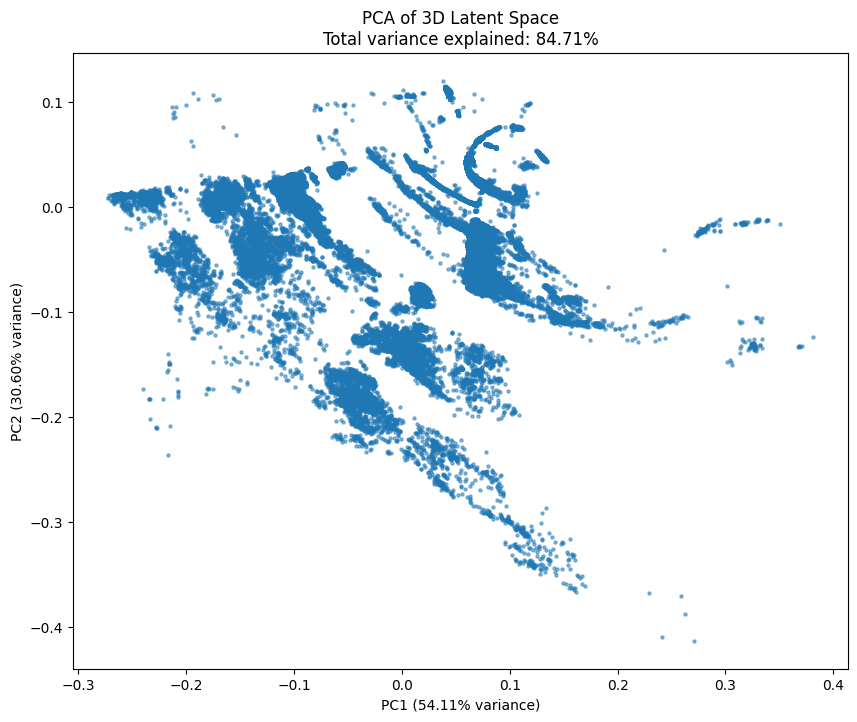

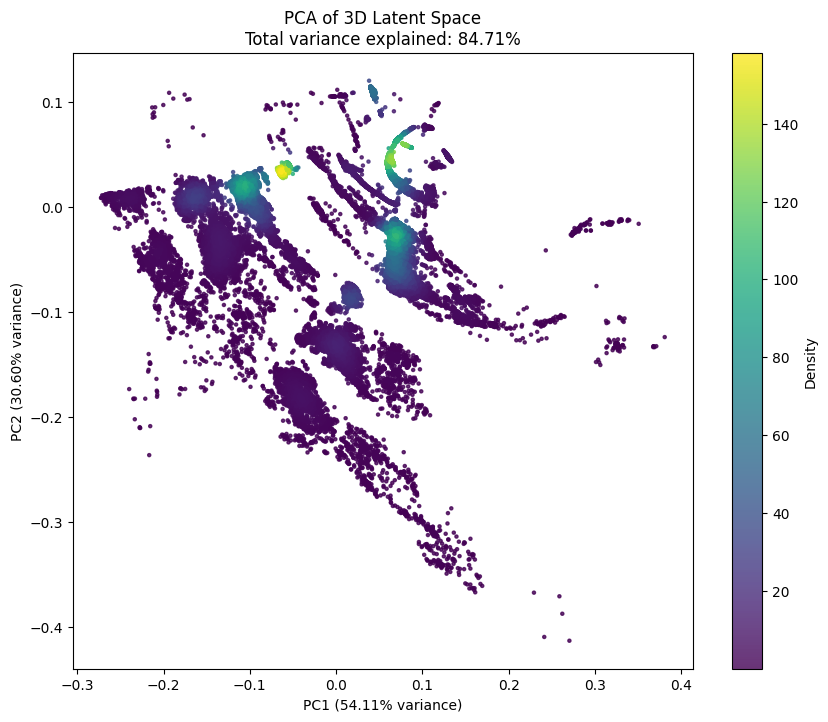

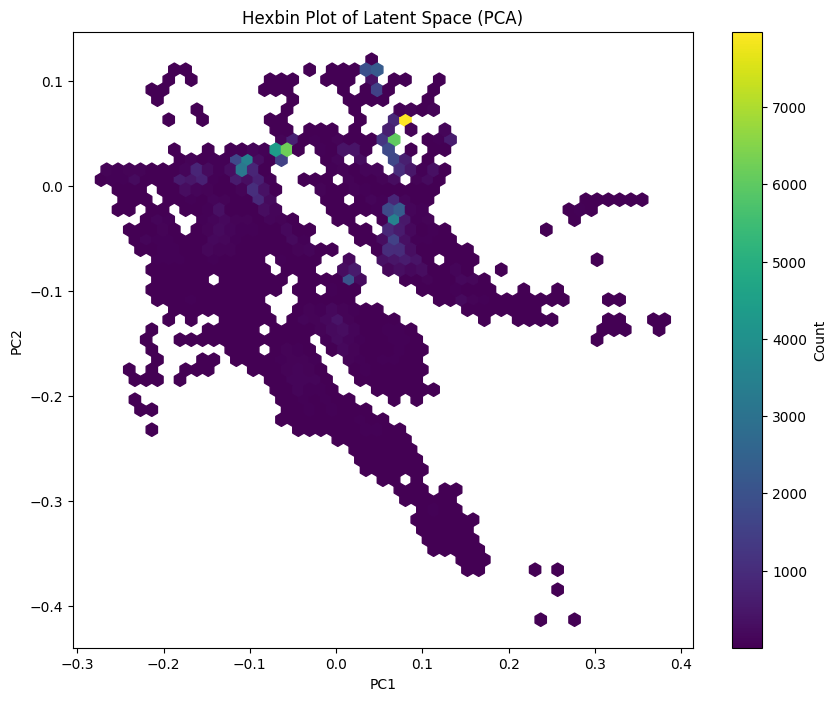

Top 2 principal components:
PC1: [-0.14437658 -0.62969368  0.76330942]
PC2: [0.9651535  0.0805277  0.24898598]


In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
import pickle

# Function to encode all data points using the trained model
def encode_all_data(params, data, model, batch_size=1024):
    """
    Encodes all data points in batches to avoid memory issues
    """
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division
    
    # Pre-allocate array for embeddings
    embeddings = np.zeros((num_samples, latent_dim))
    
    # Process in batches
    for i in tqdm(range(num_batches), desc="Encoding data"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch = data[start_idx:end_idx]
        
        # Get embeddings for this batch
        _, batch_embeddings = model.apply({'params': params}, batch)
        embeddings[start_idx:end_idx] = np.array(batch_embeddings)
    
    return embeddings

# Function to compute and visualize PCA
def visualize_latent_space_pca(embeddings, save_path=None):
    """
    Computes PCA with 2 components and creates a scatter plot
    """
    # Apply PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # Compute explained variance
    explained_variance = pca.explained_variance_ratio_
    total_variance = sum(explained_variance) * 100
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, s=5)
    
    # Add labels and title
    plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
    plt.title(f"PCA of {latent_dim}D Latent Space\nTotal variance explained: {total_variance:.2f}%")
    
    # Add colorbar for density
    from scipy.stats import gaussian_kde
    xy = np.vstack([embeddings_2d[:, 0], embeddings_2d[:, 1]])
    density = gaussian_kde(xy)(xy)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                c=density, s=5, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Density')
    
    # Add labels and title
    plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
    plt.title(f"PCA of {latent_dim}D Latent Space\nTotal variance explained: {total_variance:.2f}%")
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return embeddings_2d, pca

# Function to visualize with 2D hexbin plot (alternative visualization)
def visualize_latent_space_hexbin(embeddings_2d, save_path=None):
    """
    Creates a hexbin plot for better visualization of dense regions
    """
    plt.figure(figsize=(10, 8))
    hb = plt.hexbin(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                   gridsize=50, cmap='viridis', mincnt=1)
    plt.colorbar(hb, label='Count')
    
    # Add labels
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Hexbin Plot of Latent Space (PCA)")
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Main visualization function
def visualize_latent_space(model_path, data, save_path=None):
    """
    Main function to load model, encode data, and visualize latent space
    """
    # Load model
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    params = model_data['params']
    
    # Create model architecture (same as during training)
    model = Autoencoder(hidden_dim=hidden_dim, latent_dim=latent_dim)
    
    print(f"Encoding {data.shape[0]} data points to {latent_dim}D latent space...")
    
    # Get embeddings for all data points
    embeddings = encode_all_data(params, data, model)
    
    print("Computing PCA and creating visualizations...")
    
    # Visualize using PCA
    embeddings_2d, pca = visualize_latent_space_pca(embeddings, save_path)
    
    # Alternative visualization using hexbin
    visualize_latent_space_hexbin(embeddings_2d, 
                                 save_path.replace('.png', '_hexbin.png') if save_path else None)
    
    # Print top principal components
    print("Top 2 principal components:")
    for i, component in enumerate(pca.components_[:2]):
        print(f"PC{i+1}: {component}")
    
    return embeddings, embeddings_2d, pca

embeddings, embeddings_2d, pca = visualize_latent_space('bispectrum_autoencoder_model.pkl', data=jnp.array(bispectra))

In [1]:
raise Error

NameError: name 'Error' is not defined

In [35]:
from tqdm import tqdm



def invert(bs):

    master_rng = jax.random.PRNGKey(0)

    best_loss = np.inf
    best_geometry = None

    for _ in range(20):
        # 1) split RNG, sample a fresh init
        master_rng, subkey = jax.random.split(master_rng)
        init_pts = jax.random.normal(subkey, (15,3), jnp.float64)

        # 2) first inversion
        final_pts = invert_with_adam(bs, init_pts, num_iters=10000)

        # 3) cluster the result
        stacked = stack_points(np.array(final_pts))

        # 4) second inversion on clustered points
        if stacked.shape[0] > 0:
            pred_geometry = invert_with_adam(bs, stacked, num_iters=10000)
            loss = np.mean(np.abs(compute_bispectrum_for(pred_geometry) - bs))
        else:
            loss = np.inf


        # 5) keep if best
        if loss < best_loss:
            best_loss = loss
            best_geometry = pred_geometry

    return best_geometry


def get_errors(geometries):
    bispectra = [compute_bispectrum_for(geometry) for geometry in geometries]
    encoded_samples = encode_data(state.params, bispectra, model)
    decoded_samples = decode_data(state.params, encoded_samples, model)
    errors = []
    for i in tqdm(range(len(decoded_samples))):
        reconstructed_geometry = invert(decoded_samples[i])
        errors.append(alignment_mae(geometries[i], reconstructed_geometry))
    return errors

results = get_errors(test_geometries)

100%|██████████| 100/100 [3:14:12<00:00, 116.53s/it] 


99


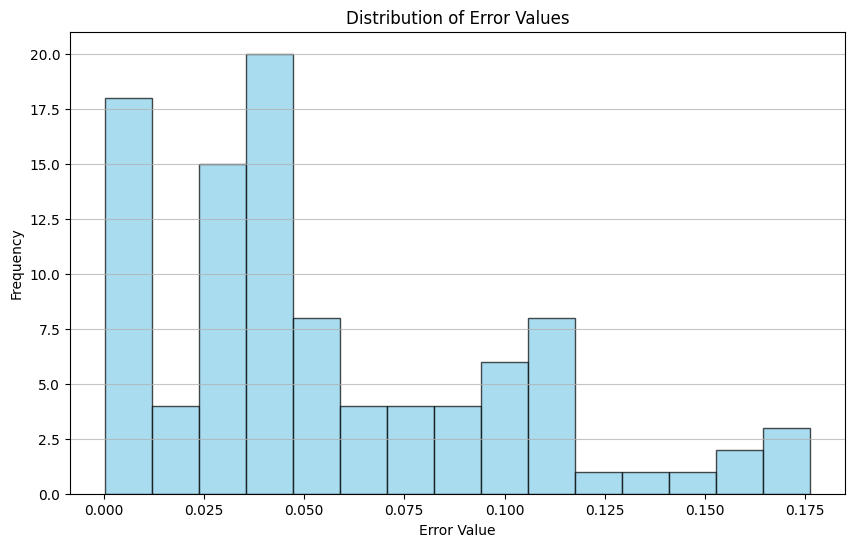

0.055671568778763114


In [37]:
invalid_count = 0

for result in results: 
    if type(result) == tuple:
        invalid_count += 1

print(invalid_count)

errors = [result[0] for result in results if type(result) == tuple]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Error Values')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(np.mean(errors))

In [43]:
max(errors)

Array(0.17612712, dtype=float64)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


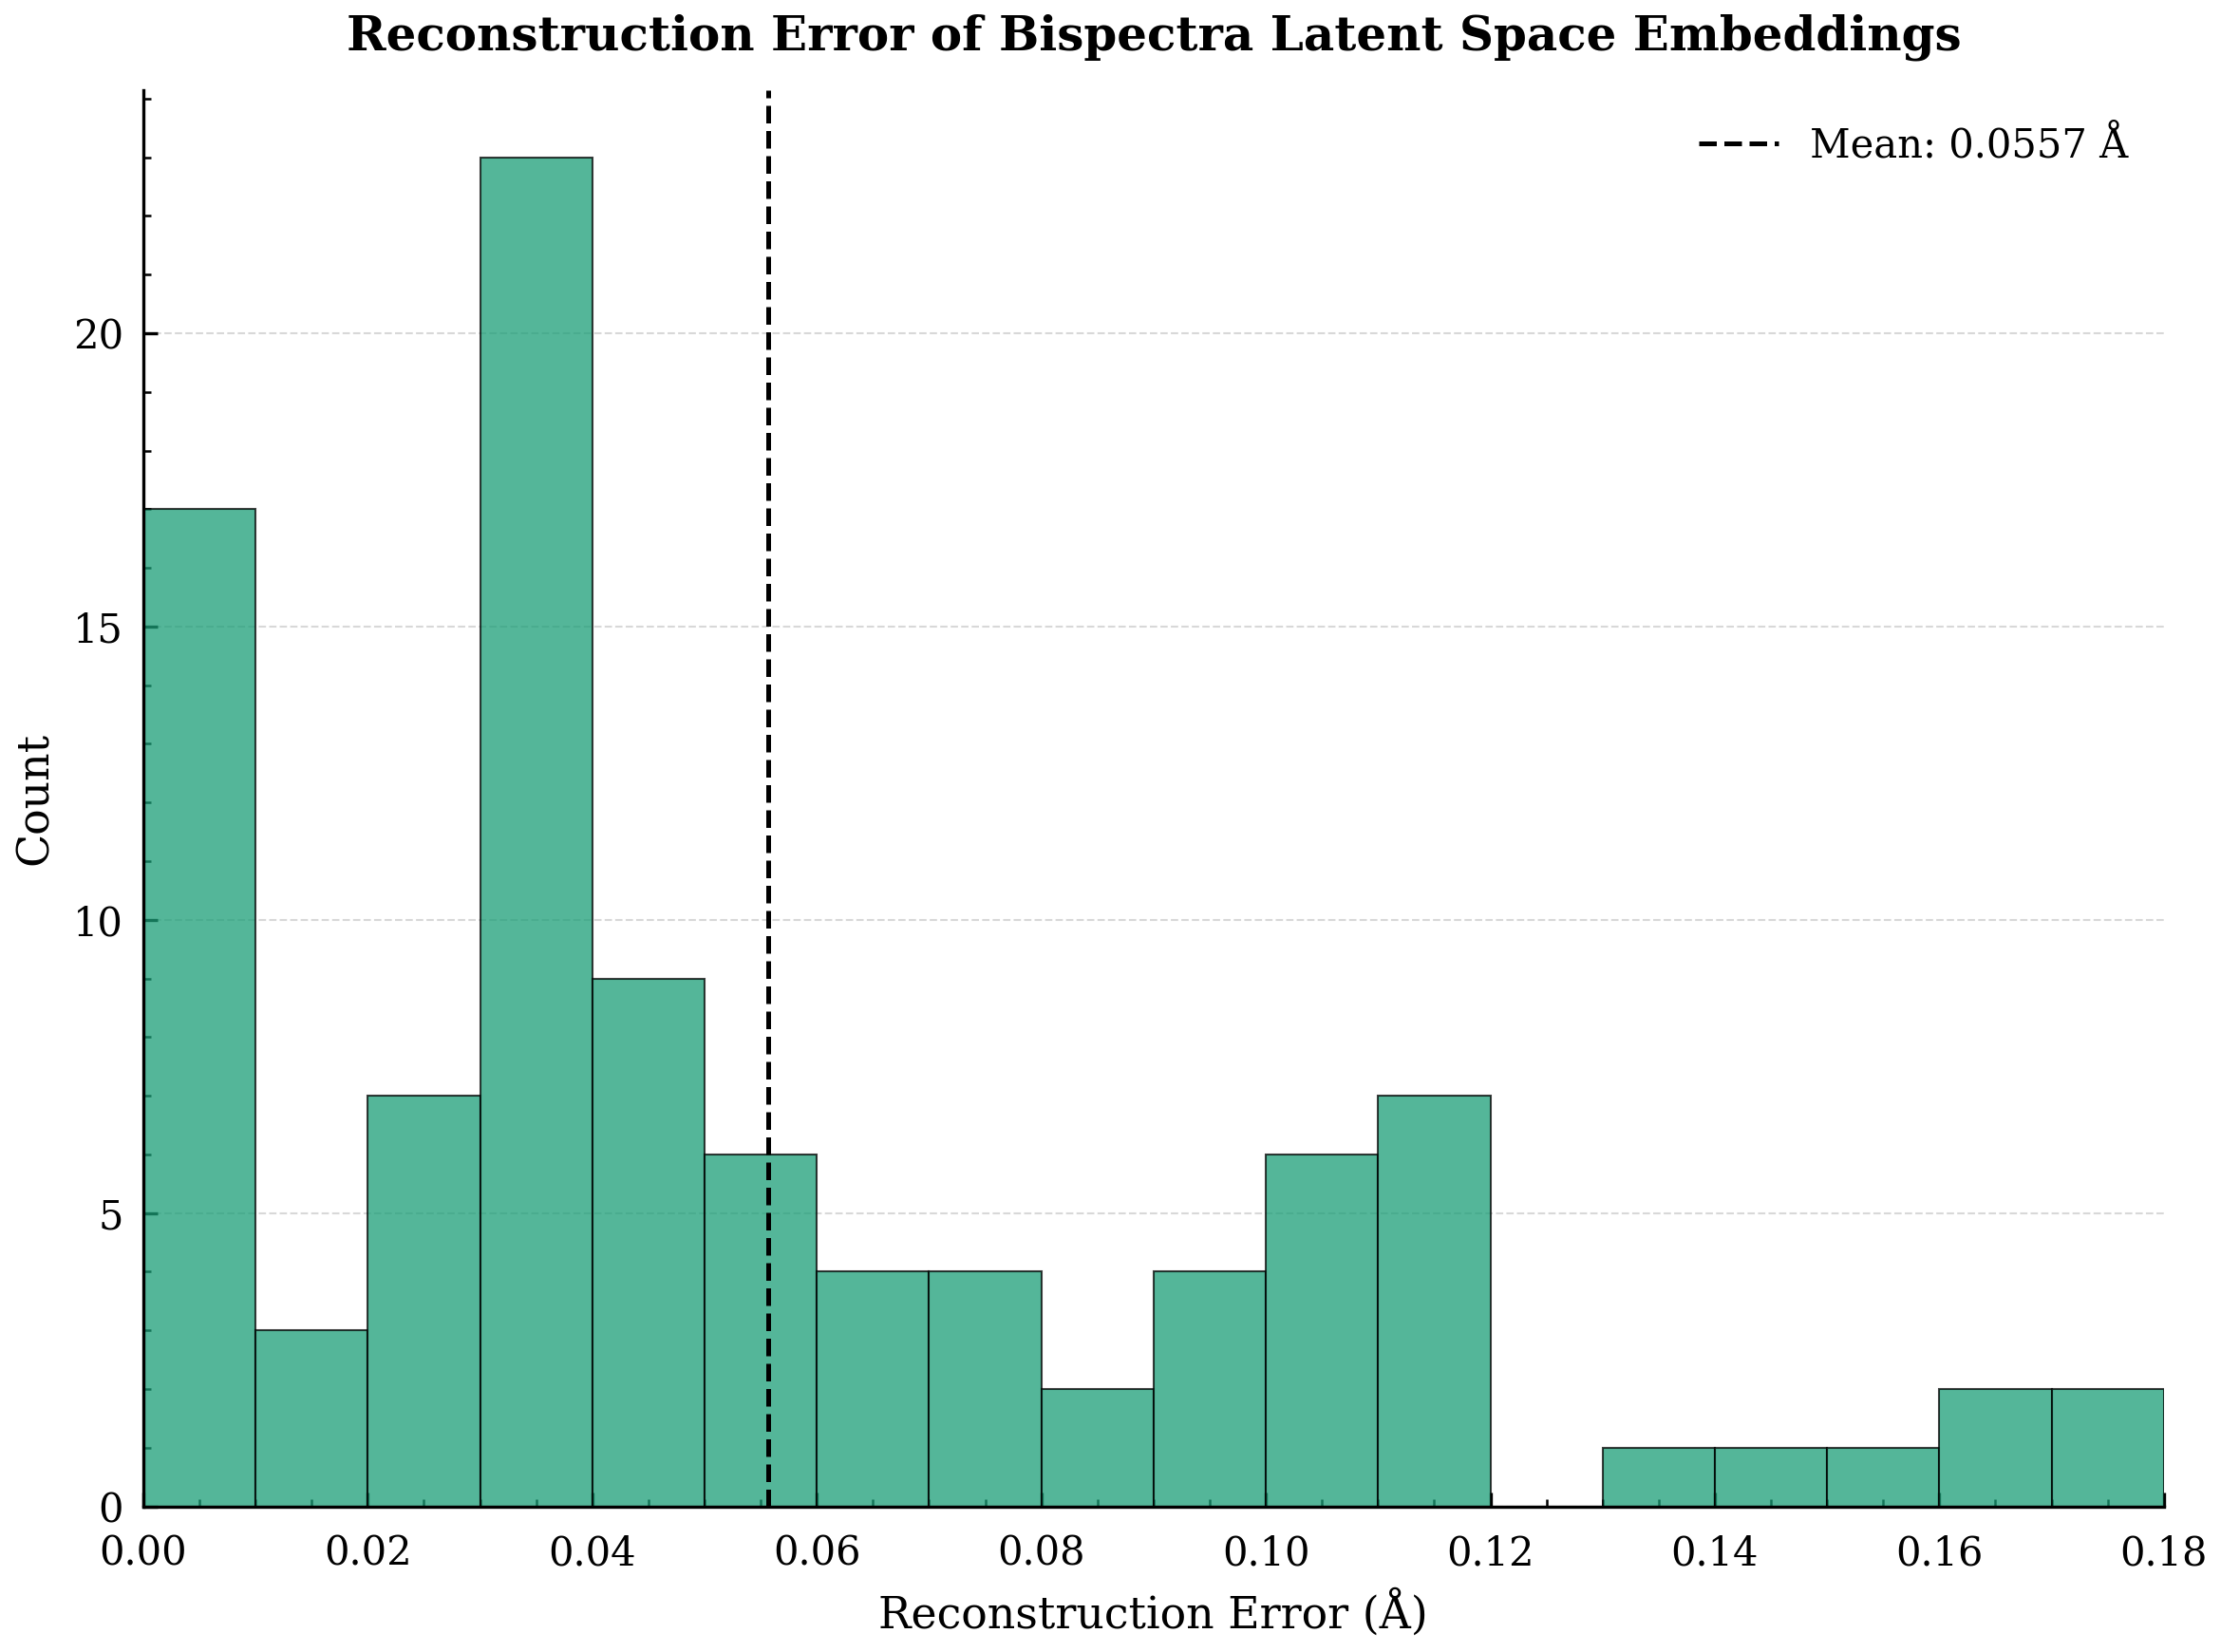

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Set publication-quality plot style
plt.rcParams.update({
    'text.usetex': False,  # Don't use LaTeX for text rendering
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
    'mathtext.fontset': 'cm',  # Still use Computer Modern for math
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.6,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 3.5,
    'ytick.major.size': 3.5,
    'xtick.minor.size': 2.0,
    'ytick.minor.size': 2.0,
    'axes.axisbelow': True,
    'axes.grid': False,
})

# Convert to numpy array for easier handling
alignment_maes_array = np.array(errors)

# Calculate statistics for annotation
mean_error = np.mean(alignment_maes_array)
median_error = np.median(alignment_maes_array)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create bins with fixed width of 0.01 from 0 to 0.18 (18 bins)
bins = np.linspace(0, 0.18, 19)  # 19 edges for 18 bins

# Create histogram with colorblind-friendly color
hist, bins, patches = ax.hist(alignment_maes_array, bins=bins, 
                             color='#1b9e77', edgecolor='black', 
                             linewidth=0.5, alpha=0.75)

# Add vertical line at the mean with dashed style
ax.axvline(mean_error, color='black', linestyle='--', linewidth=1.2, 
           label=f'Mean: {mean_error:.4f} Å')

# Clean up the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.5, axis='y')

# Set axis labels with proper formatting and notation
ax.set_xlabel(r'Reconstruction Error (Å)', fontweight='normal')
ax.set_ylabel(r'Count', fontweight='normal')
ax.set_title(r'Reconstruction Error of Bispectra Latent Space Embeddings', fontweight='bold', pad=10)

# Add minor ticks
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

# Function to format x-axis with 2 decimal places
def format_with_2dp(x, pos):
    return f'{x:.2f}'

# Format x-axis to use 2 decimal places
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_with_2dp))

# Add padding between axes and labels
ax.tick_params(axis='x', pad=7)  # Add padding between x-axis and its labels
ax.tick_params(axis='y', pad=5)  # Add padding between y-axis and its labels

# Add legend with mean value
ax.legend(frameon=False, loc='upper right')

# Set x-axis limits to match our bin range
ax.set_xlim(0, 0.18)

# Ensure y-axis starts at 0
ax.set_ylim(bottom=0)

# Adjust layout to match other figures
plt.tight_layout()

# Save the figure in multiple formats suitable for publication
plt.savefig('alignment_error_distribution.pdf', dpi=600, bbox_inches='tight')
plt.savefig('alignment_error_distribution.png', dpi=600, bbox_inches='tight')
plt.savefig('alignment_error_distribution.eps', format='eps', dpi=600, bbox_inches='tight')

plt.show()

In [36]:
# Save the results to a file
import pickle

# Define the filename
results_filename = 'qm9_autoencoder_results_2_points.pkl'

# Save the results using pickle
with open(results_filename, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {results_filename}")

# If you need to load the results later, you can use:
# with open(results_filename, 'rb') as f:
#     loaded_results = pickle.load(f)


Results saved to qm9_autoencoder_results_2_points.pkl
